In [98]:
# ==============================================================================
# TUGAS-A-1-EKSPLORASI ANALISIS SENTIMEN
# NAMA: ALFA RENALDO ALUSKA
# NRP: 5026221144
# ==============================================================================

# 1: Praproses data
Untuk nomor 1. Sudah dilakukan di kelas Ibu Irma, nanti hanya uplaod file output saja.

#2: Baseline Model (BoW+NB)
Untuk nomor 2: Bag of Words, Naive Bayes.

In [99]:
# === BAGIAN 2: BASELINE MODEL ===

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from collections import Counter

# Load dataset
df = pd.read_csv("7-garudaindonesia_news_cleaned_simple.csv")
df.columns = df.columns.str.strip()

# Pilih kolom teks dan label
X = df['konten_normalized']
y = df['sentiment']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Buat pipeline BoW + NB
pipeline_bow_nb_asli = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB())
])

# Latih model baseline
pipeline_bow_nb_asli.fit(X_train, y_train)
y_pred_baseline = pipeline_bow_nb_asli.predict(X_test)

# Evaluasi lengkap
print("\n=== BASELINE MODEL (BoW + NB) ===")
acc_bow_nb_asli  = accuracy_score(y_test, y_pred_baseline)
report_bow_nb_asli  = classification_report(y_test, y_pred_baseline, zero_division=0, output_dict=True)

print(f"Akurasi: {acc_bow_nb_asli:.4f}\n")
print("F1-Score per Kelas:")
for label in ['Negative', 'Neutral', 'Positive']:
    f1 = report_bow_nb_asli[label]['f1-score']
    precision = report_bow_nb_asli[label]['precision']
    recall = report_bow_nb_asli[label]['recall']
    support = report_bow_nb_asli[label]['support']
    print(f"- {label:<8} | Precision: {precision:.2f} | Recall: {recall:.2f} | F1: {f1:.2f} | Support: {support}")

print(f"\nMacro Avg F1-Score   : {report_bow_nb_asli['macro avg']['f1-score']:.4f}")
print(f"Weighted Avg F1-Score: {report_bow_nb_asli['weighted avg']['f1-score']:.4f}")


=== BASELINE MODEL (BoW + NB) ===
Akurasi: 0.8404

F1-Score per Kelas:
- Negative | Precision: 0.82 | Recall: 0.86 | F1: 0.84 | Support: 37.0
- Neutral  | Precision: 0.75 | Recall: 0.53 | F1: 0.62 | Support: 17.0
- Positive | Precision: 0.88 | Recall: 0.95 | F1: 0.92 | Support: 40.0

Macro Avg F1-Score   : 0.7928
Weighted Avg F1-Score: 0.8334


#3: Augmentasi Indobert
Context embedding.

In [100]:
# === BAGIAN 3: AUGMENTASI INDOBERT ===

!pip install -q nlpaug transformers Sastrawi
import nlpaug.augmenter.word as naw
#from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from tqdm import tqdm

# Inisialisasi IndoBERT
model_name = 'indobenchmark/indobert-base-p1'
try:
    augmenter = naw.ContextualWordEmbsAug(
        model_path=model_name,
        action="substitute",
        device='cuda'
    )
    print("✅ IndoBERT berhasil dimuat di GPU.")
except RuntimeError:
    augmenter = naw.ContextualWordEmbsAug(
        model_path=model_name,
        action="substitute",
        device='cpu'
    )
    print("⚠️ IndoBERT fallback ke CPU.")

# Inisialisasi stemmer
#stemmer = StemmerFactory().create_stemmer()

# Siapkan data untuk augmentasi
neutral_indices = y_train[y_train == 'Neutral'].index
negative_indices = y_train[y_train == 'Negative'].index

neutral_texts_to_aug = df.loc[neutral_indices]['konten_normalized'].tolist()
negative_texts_to_aug = df.loc[negative_indices]['konten_normalized'].tolist()

n_positive = Counter(y_train)['Positive']
n_neutral = Counter(y_train)['Neutral']
n_negative = Counter(y_train)['Negative']

# n_aug_neutral = max(1, round((n_positive - n_neutral) / n_neutral))
#n_aug_negative = max(1, round((n_positive - n_negative) / n_negative))
target_per_class = Counter(y_train)['Positive']  # kita samakan ke jumlah Positive
#n_aug_neutral = max(0, round((target_per_class - n_neutral) / n_neutral))
#n_aug_negative = max(0, round((target_per_class - n_negative) / n_negative))
n_aug_neutral = target_per_class - n_neutral  # jumlah teks tambahan yang dibutuhkan
n_aug_negative = target_per_class - n_negative


print(f"\nTarget distribusi per kelas: {target_per_class}")
print(f"Jumlah data sebelum augmentasi:")
print(f"- Neutral  : {n_neutral}")
print(f"- Negative : {n_negative}")
print(f"- Positive : {n_positive}")
print(f"\nTarget Augmentasi:")
print(f"- Neutral  → {n_aug_neutral}x")
print(f"- Negative → {n_aug_negative}x")

# Augmentasi dengan progress bar
#print("\nAugmentasi teks Neutral...")
#new_neutral_texts = [augmenter.augment(text, n=n_aug_neutral) for text in tqdm(neutral_texts_to_aug, desc='Augment Neutral')]
#new_neutral_texts = sum(new_neutral_texts, [])
print("\nAugmentasi teks Neutral...")
new_neutral_texts = []
i = 0
while len(new_neutral_texts) < n_aug_neutral:
    text = neutral_texts_to_aug[i % len(neutral_texts_to_aug)]
    new_neutral_texts.extend(augmenter.augment(text, n=1))
    i += 1
#for text in tqdm(neutral_texts_to_aug, desc='Augment Neutral'):
#    new_neutral_texts.extend(augmenter.augment(text, n=1))
#    if len(new_neutral_texts) >= n_aug_neutral:
#        break

#print("Augmentasi teks Negative...")
#new_negative_texts = [augmenter.augment(text, n=n_aug_negative) for text in tqdm(negative_texts_to_aug, desc='Augment Negative')]
#new_negative_texts = sum(new_negative_texts, [])
print("Augmentasi teks Negative...")
new_negative_texts = []
i = 0
while len(new_negative_texts) < n_aug_negative:
    text = negative_texts_to_aug[i % len(negative_texts_to_aug)]
    new_negative_texts.extend(augmenter.augment(text, n=1))
    i += 1


# Stemming dengan progress bar
#stemmed_new_neutral = [stemmer.stem(text) for text in tqdm(new_neutral_texts, desc='Stemming Neutral')]
#stemmed_new_negative = [stemmer.stem(text) for text in tqdm(new_negative_texts, desc='Stemming Negative')]

#new_neutral_labels = ['Neutral'] * len(stemmed_new_neutral)
#new_negative_labels = ['Negative'] * len(stemmed_new_negative)

# Gabungkan data latih
#X_train_aug_bert = pd.concat([X_train.reset_index(drop=True), pd.Series(stemmed_new_neutral), pd.Series(stemmed_new_negative)], ignore_index=True)
#y_train_aug_bert = pd.concat([y_train.reset_index(drop=True), pd.Series(new_neutral_labels), pd.Series(new_negative_labels)], ignore_index=True)

new_neutral_labels = ['Neutral'] * len(new_neutral_texts)
new_negative_labels = ['Negative'] * len(new_negative_texts)

# Gabungkan data latih
X_train_aug_bert = pd.concat([X_train.reset_index(drop=True), pd.Series(new_neutral_texts), pd.Series(new_negative_texts)], ignore_index=True)
y_train_aug_bert = pd.concat([y_train.reset_index(drop=True), pd.Series(new_neutral_labels), pd.Series(new_negative_labels)], ignore_index=True)


print(f"\nDistribusi Setelah Augmentasi: {Counter(y_train_aug_bert)}")


✅ IndoBERT berhasil dimuat di GPU.

Target distribusi per kelas: 161
Jumlah data sebelum augmentasi:
- Neutral  : 68
- Negative : 146
- Positive : 161

Target Augmentasi:
- Neutral  → 93x
- Negative → 15x

Augmentasi teks Neutral...
Augmentasi teks Negative...

Distribusi Setelah Augmentasi: Counter({'Neutral': 161, 'Positive': 161, 'Negative': 161})


#4: Train Augmented BoW+NB

In [101]:
# Latih ulang model dengan data augmented
pipeline_bow_nb_aug.fit(X_train_aug_bert, y_train_aug_bert)
y_pred_aug_bert = pipeline_bow_nb_aug.predict(X_test)

# Evaluasi model augmented
print("\n=== MODEL SETELAH AUGMENTASI (IndoBERT) ===")
acc_aug_bert = accuracy_score(y_test, y_pred_aug_bert)
report_aug_bert = classification_report(y_test, y_pred_aug_bert, zero_division=0, output_dict=True)

print(f"Akurasi: {acc_aug_bert:.4f}\n")
print("F1-Score per Kelas:")
for label in ['Negative', 'Neutral', 'Positive']:
    f1 = report_aug_bert[label]['f1-score']
    precision = report_aug_bert[label]['precision']
    recall = report_aug_bert[label]['recall']
    support = report_aug_bert[label]['support']
    print(f"- {label:<8} | Precision: {precision:.2f} | Recall: {recall:.2f} | F1: {f1:.2f} | Support: {support}")

print(f"\nMacro Avg F1-Score   : {report_aug_bert['macro avg']['f1-score']:.4f}")
print(f"Weighted Avg F1-Score: {report_aug_bert['weighted avg']['f1-score']:.4f}")

# Perbandingan akhir
f1_baseline = report_bow_nb_asli['Neutral']['f1-score']
f1_augmented = report_aug_bert['Neutral']['f1-score']

print("\n=== PERBANDINGAN F1-SCORE (Neutral) ===")
print(f"1. Baseline (Asli):           {f1_baseline:.4f}")
print(f"2. IndoBERT Augmentation:     {f1_augmented:.4f}")

# Simpan hasil ke CSV
df_augmented_bert = pd.DataFrame({
    'final_text': X_train_aug_bert,
    'score_label': y_train_aug_bert
})
df_augmented_bert.to_csv("garuda_augmented_bert.csv", index=False)
print(f"\n✅ Data augmented disimpan sebagai 'garuda_augmented_bert.csv' ({len(df_augmented_bert)} baris)")



=== MODEL SETELAH AUGMENTASI (IndoBERT) ===
Akurasi: 0.8617

F1-Score per Kelas:
- Negative | Precision: 0.86 | Recall: 0.84 | F1: 0.85 | Support: 37.0
- Neutral  | Precision: 0.75 | Recall: 0.71 | F1: 0.73 | Support: 17.0
- Positive | Precision: 0.90 | Recall: 0.95 | F1: 0.93 | Support: 40.0

Macro Avg F1-Score   : 0.8345
Weighted Avg F1-Score: 0.8602

=== PERBANDINGAN F1-SCORE (Neutral) ===
1. Baseline (Asli):           0.6207
2. IndoBERT Augmentation:     0.7273

✅ Data augmented disimpan sebagai 'garuda_augmented_bert.csv' (483 baris)


#5: Hasil & Banding BoW+NB


=== CEK DATA LATIH SETELAH AUGMENTASI ===
Jumlah data latih sebelum augmentasi: 375
Jumlah data latih setelah augmentasi: 483

Distribusi label sebelum augmentasi:
Counter({'Positive': 161, 'Negative': 146, 'Neutral': 68})

Distribusi label setelah augmentasi:
Counter({'Neutral': 161, 'Positive': 161, 'Negative': 161})

Contoh hasil augmentasi Neutral:
- tempo cowok jakarta presiden amerika serikat as donald trump telah mengumumkan komitmen indonesia untuk membeli cita boeing trump mengatakan rencana itu sebagai bagian dari kesepakatan dagang kedua negara setelah dirinya berdiskusi langsung dengan presiden prabowo subianto baca berita dengan sedikit iklan klik di sini indonesia telah berkomitmen untuk tindak inspir energi as senilai us miliar produk pertanian amerika senilai us miliar dan jet boeing banyak di antaranya adalah seri tulis trump melalui unggahan di media sosial truth social pada selasa juli waktu as scroll ke bawah untuk melanjutkan membaca baca berita dengan sedikit ikl

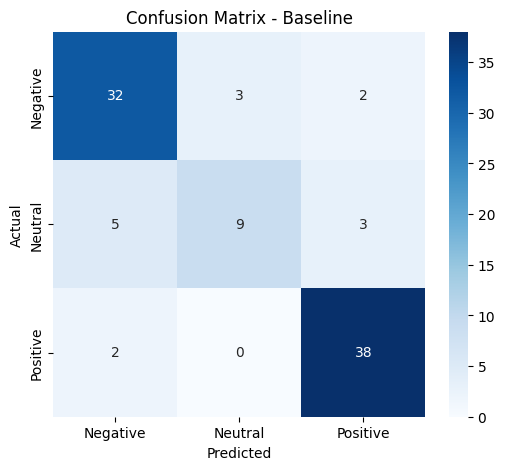


Metrik per Kelas (Baseline):
- Negative | Precision: 0.82 | Recall: 0.86 | F1: 0.84 | Support: 37.0
- Neutral  | Precision: 0.75 | Recall: 0.53 | F1: 0.62 | Support: 17.0
- Positive | Precision: 0.88 | Recall: 0.95 | F1: 0.92 | Support: 40.0

Macro Avg F1-Score   : 0.7928
Weighted Avg F1-Score: 0.8334

=== AUGMENTED: STATISTIKA DESKRIPTIF ===
Distribusi label setelah augmentasi:
Counter({'Neutral': 161, 'Positive': 161, 'Negative': 161})

Distribusi Label Asli (y_test):
Counter({'Positive': 40, 'Negative': 37, 'Neutral': 17})

Distribusi Prediksi (Augmented):
Counter({'Positive': 42, 'Negative': 36, 'Neutral': 16})


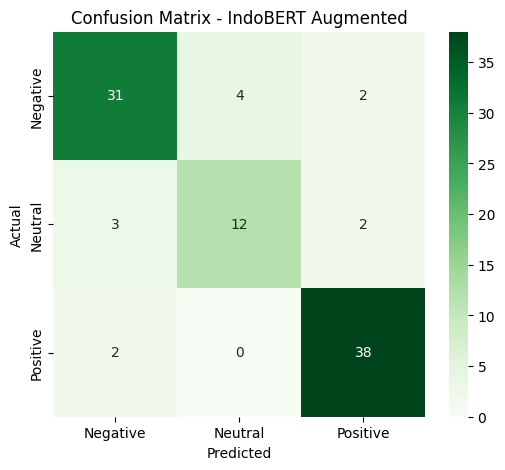


Metrik per Kelas (Augmented):
- Negative | Precision: 0.86 | Recall: 0.84 | F1: 0.85 | Support: 37.0
- Neutral  | Precision: 0.75 | Recall: 0.71 | F1: 0.73 | Support: 17.0
- Positive | Precision: 0.90 | Recall: 0.95 | F1: 0.93 | Support: 40.0

Macro Avg F1-Score   : 0.8345
Weighted Avg F1-Score: 0.8602


In [102]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from collections import Counter

labels = ['Negative', 'Neutral', 'Positive']

# === CEK ISI DATASET HASIL AUGMENTASI ===
print("\n=== CEK DATA LATIH SETELAH AUGMENTASI ===")
print(f"Jumlah data latih sebelum augmentasi: {len(X_train)}")
print(f"Jumlah data latih setelah augmentasi: {len(X_train_aug_bert)}")

print("\nDistribusi label sebelum augmentasi:")
print(Counter(y_train))

print("\nDistribusi label setelah augmentasi:")
print(Counter(y_train_aug_bert))

#print("\nContoh hasil augmentasi Neutral:")
#for i in range(3):
#    print("-", stemmed_new_neutral[i])

print("\nContoh hasil augmentasi Neutral:")
for i in range(3):
    print("-", new_neutral_texts[i])


#print("\nContoh hasil augmentasi Negative:")
#for i in range(3):
#    print("-", stemmed_new_negative[i])

print("\nContoh hasil augmentasi Negative:")
for i in range(3):
    print("-", new_negative_texts[i])


# === BASELINE: STATISTIKA DESKRIPTIF ===
print("\n=== BASELINE: STATISTIKA DESKRIPTIF ===")
print("Distribusi label di seluruh dataset:")
print(Counter(df['sentiment']))

print("\nDistribusi Label Asli (y_test):")
print(Counter(y_test))

print("\nDistribusi Prediksi (Baseline):")
print(Counter([str(label) for label in y_pred_baseline]))

cm_base = confusion_matrix(y_test, y_pred_baseline, labels=labels)
plt.figure(figsize=(6,5))
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Baseline")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nMetrik per Kelas (Baseline):")
for label in labels:
    p = report_bow_nb_asli[label]['precision']
    r = report_bow_nb_asli[label]['recall']
    f1 = report_bow_nb_asli[label]['f1-score']
    s = report_bow_nb_asli[label]['support']
    print(f"- {label:<8} | Precision: {p:.2f} | Recall: {r:.2f} | F1: {f1:.2f} | Support: {s}")

print(f"\nMacro Avg F1-Score   : {report_bow_nb_asli['macro avg']['f1-score']:.4f}")
print(f"Weighted Avg F1-Score: {report_bow_nb_asli['weighted avg']['f1-score']:.4f}")

# === AUGMENTED: STATISTIKA DESKRIPTIF ===
print("\n=== AUGMENTED: STATISTIKA DESKRIPTIF ===")
print("Distribusi label setelah augmentasi:")
print(Counter(y_train_aug_bert))

print("\nDistribusi Label Asli (y_test):")
print(Counter(y_test))

print("\nDistribusi Prediksi (Augmented):")
print(Counter([str(label) for label in y_pred_aug_bert]))


cm_aug = confusion_matrix(y_test, y_pred_aug_bert, labels=labels)
plt.figure(figsize=(6,5))
sns.heatmap(cm_aug, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - IndoBERT Augmented")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nMetrik per Kelas (Augmented):")
for label in labels:
    p = report_aug_bert[label]['precision']
    r = report_aug_bert[label]['recall']
    f1 = report_aug_bert[label]['f1-score']
    s = report_aug_bert[label]['support']
    print(f"- {label:<8} | Precision: {p:.2f} | Recall: {r:.2f} | F1: {f1:.2f} | Support: {s}")

print(f"\nMacro Avg F1-Score   : {report_aug_bert['macro avg']['f1-score']:.4f}")
print(f"Weighted Avg F1-Score: {report_aug_bert['weighted avg']['f1-score']:.4f}")



#6: Perbandingan Lanjutan BoW+NB

In [103]:
import pandas as pd

labels = ['Negative', 'Neutral', 'Positive']
kelas_all = labels + ['macro avg', 'weighted avg']

# === Precision Table ===
precision_rows = []
for label in kelas_all:
    precision_rows.append({
        "Kelas": label.title() if "avg" in label else label,
        "Baseline": f"{report_bow_nb_asli[label]['precision']:.2f}",
        "Augmented": f"{report_aug_bert[label]['precision']:.2f}"
    })
df_precision = pd.DataFrame(precision_rows)
print("\n=== PERBANDINGAN PRECISION ===")
print(df_precision.to_string(index=False))

# === Recall Table ===
recall_rows = []
for label in kelas_all:
    recall_rows.append({
        "Kelas": label.title() if "avg" in label else label,
        "Baseline": f"{report_nb[label]['recall']:.2f}",
        "Augmented": f"{report_aug_bert[label]['recall']:.2f}"
    })
df_recall = pd.DataFrame(recall_rows)
print("\n=== PERBANDINGAN RECALL ===")
print(df_recall.to_string(index=False))

# === F1-Score Table ===
f1_rows = []
for label in kelas_all:
    f1_rows.append({
        "Kelas": label.title() if "avg" in label else label,
        "Baseline": f"{report_nb[label]['f1-score']:.2f}",
        "Augmented": f"{report_aug_bert[label]['f1-score']:.2f}"
    })
df_f1 = pd.DataFrame(f1_rows)
print("\n=== PERBANDINGAN F1-SCORE ===")
print(df_f1.to_string(index=False))


# Buat tabel overall metrik
overall_rows = [
    {
        "Metrik": "Accuracy",
        "Baseline": f"{accuracy_score(y_test, y_pred_baseline):.4f}",
        "Augmented": f"{accuracy_score(y_test, y_pred_aug_bert):.4f}"
    },
    {
        "Metrik": "Macro Precision",
        "Baseline": f"{report_nb['macro avg']['precision']:.2f}",
        "Augmented": f"{report_aug_bert['macro avg']['precision']:.2f}"
    },
    {
        "Metrik": "Macro Recall",
        "Baseline": f"{report_nb['macro avg']['recall']:.2f}",
        "Augmented": f"{report_aug_bert['macro avg']['recall']:.2f}"
    },
    {
        "Metrik": "Macro F1",
        "Baseline": f"{report_nb['macro avg']['f1-score']:.2f}",
        "Augmented": f"{report_aug_bert['macro avg']['f1-score']:.2f}"
    },
    {
        "Metrik": "Weighted Precision",
        "Baseline": f"{report_nb['weighted avg']['precision']:.2f}",
        "Augmented": f"{report_aug_bert['weighted avg']['precision']:.2f}"
    },
    {
        "Metrik": "Weighted Recall",
        "Baseline": f"{report_nb['weighted avg']['recall']:.2f}",
        "Augmented": f"{report_aug_bert['weighted avg']['recall']:.2f}"
    },
    {
        "Metrik": "Weighted F1",
        "Baseline": f"{report_nb['weighted avg']['f1-score']:.2f}",
        "Augmented": f"{report_aug_bert['weighted avg']['f1-score']:.2f}"
    }
]

df_overall = pd.DataFrame(overall_rows)
print("\n=== TABEL OVERALL METRIK BASELINE vs AUGMENTED ===")
print(df_overall.to_string(index=False))



=== PERBANDINGAN PRECISION ===
       Kelas Baseline Augmented
    Negative     0.82      0.86
     Neutral     0.75      0.75
    Positive     0.88      0.90
   Macro Avg     0.82      0.84
Weighted Avg     0.83      0.86

=== PERBANDINGAN RECALL ===
       Kelas Baseline Augmented
    Negative     0.86      0.84
     Neutral     0.53      0.71
    Positive     0.95      0.95
   Macro Avg     0.78      0.83
Weighted Avg     0.84      0.86

=== PERBANDINGAN F1-SCORE ===
       Kelas Baseline Augmented
    Negative     0.84      0.85
     Neutral     0.62      0.73
    Positive     0.92      0.93
   Macro Avg     0.79      0.83
Weighted Avg     0.83      0.86

=== TABEL OVERALL METRIK BASELINE vs AUGMENTED ===
            Metrik Baseline Augmented
          Accuracy   0.8404    0.8617
   Macro Precision     0.82      0.84
      Macro Recall     0.78      0.83
          Macro F1     0.79      0.83
Weighted Precision     0.83      0.86
   Weighted Recall     0.84      0.86
       Weighte

#7: Eksplor BoW + LR
Bag of Words, Linear Regression

In [104]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# === BoW + LR (Asli) ===
pipeline_bow_lr = Pipeline([
    ('bow', CountVectorizer()),
    ('clf', LogisticRegression(max_iter=1000))
])
pipeline_bow_lr.fit(X_train, y_train)
y_pred_bow_lr = pipeline_bow_lr.predict(X_test)
report_bow_lr = classification_report(y_test, y_pred_bow_lr, output_dict=True, zero_division=0)
acc_bow_lr = accuracy_score(y_test, y_pred_bow_lr)

# === BoW + LR (Augmented) ===
pipeline_bow_lr_aug = Pipeline([
    ('bow', CountVectorizer()),
    ('clf', LogisticRegression(max_iter=1000))
])
pipeline_bow_lr_aug.fit(X_train_aug_bert, y_train_aug_bert)
y_pred_bow_lr_aug = pipeline_bow_lr_aug.predict(X_test)
report_bow_lr_aug = classification_report(y_test, y_pred_bow_lr_aug, output_dict=True, zero_division=0)
acc_bow_lr_aug = accuracy_score(y_test, y_pred_bow_lr_aug)

# === Tampilkan Perbandingan ===
print("\n=== BoW + Logistic Regression ===")
print(f"Akurasi (Asli)     : {acc_bow_lr:.4f}")
print(f"Akurasi (Augmented): {acc_bow_lr_aug:.4f}\n")

for label in ['Negative', 'Neutral', 'Positive']:
    print(f"{label} Class:")
    print(f"  F1 Asli     : {report_bow_lr[label]['f1-score']:.2f}")
    print(f"  F1 Augmented: {report_bow_lr_aug[label]['f1-score']:.2f}")

print(f"\nMacro F1 Asli     : {report_bow_lr['macro avg']['f1-score']:.4f}")
print(f"Macro F1 Augmented: {report_bow_lr_aug['macro avg']['f1-score']:.4f}")



=== BoW + Logistic Regression ===
Akurasi (Asli)     : 0.7872
Akurasi (Augmented): 0.7872

Negative Class:
  F1 Asli     : 0.85
  F1 Augmented: 0.85
Neutral Class:
  F1 Asli     : 0.43
  F1 Augmented: 0.50
Positive Class:
  F1 Asli     : 0.85
  F1 Augmented: 0.84

Macro F1 Asli     : 0.7095
Macro F1 Augmented: 0.7307


#7: Eksplor BoW + SVM
Bag of Words, Support Vector Machine

In [105]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score

# === BoW + SVM (Asli) ===
pipeline_bow_svm = Pipeline([
    ('bow', CountVectorizer()),
    ('clf', LinearSVC())
])
pipeline_bow_svm.fit(X_train, y_train)
y_pred_bow_svm = pipeline_bow_svm.predict(X_test)
report_bow_svm = classification_report(y_test, y_pred_bow_svm, output_dict=True, zero_division=0)
acc_bow_svm = accuracy_score(y_test, y_pred_bow_svm)

# === BoW + SVM (Augmented) ===
pipeline_bow_svm_aug = Pipeline([
    ('bow', CountVectorizer()),
    ('clf', LinearSVC())
])
pipeline_bow_svm_aug.fit(X_train_aug_bert, y_train_aug_bert)
y_pred_bow_svm_aug = pipeline_bow_svm_aug.predict(X_test)
report_bow_svm_aug = classification_report(y_test, y_pred_bow_svm_aug, output_dict=True, zero_division=0)
acc_bow_svm_aug = accuracy_score(y_test, y_pred_bow_svm_aug)

# === Tampilkan Perbandingan ===
print("\n=== BoW + SVM ===")
print(f"Akurasi (Asli)     : {acc_bow_svm:.4f}")
print(f"Akurasi (Augmented): {acc_bow_svm_aug:.4f}\n")

for label in ['Negative', 'Neutral', 'Positive']:
    print(f"{label} Class:")
    print(f"  F1 Asli     : {report_bow_svm[label]['f1-score']:.2f}")
    print(f"  F1 Augmented: {report_bow_svm_aug[label]['f1-score']:.2f}")

print(f"\nMacro F1 Asli     : {report_bow_svm['macro avg']['f1-score']:.4f}")
print(f"Macro F1 Augmented: {report_bow_svm_aug['macro avg']['f1-score']:.4f}")



=== BoW + SVM ===
Akurasi (Asli)     : 0.7766
Akurasi (Augmented): 0.7872

Negative Class:
  F1 Asli     : 0.84
  F1 Augmented: 0.85
Neutral Class:
  F1 Asli     : 0.43
  F1 Augmented: 0.48
Positive Class:
  F1 Asli     : 0.84
  F1 Augmented: 0.84

Macro F1 Asli     : 0.7012
Macro F1 Augmented: 0.7227


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


#8: Eksplor TF-IDF + NB
Bag of Words, Naive Bayes

In [106]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

# === TF-IDF + Naïve Bayes (Tanpa Augmentasi) ===
pipeline_nb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])
pipeline_nb.fit(X_train, y_train)
y_pred_nb = pipeline_nb.predict(X_test)
#report_nb = classification_report(y_test, y_pred_nb, output_dict=True, zero_division=0)
#acc_nb = accuracy_score(y_test, y_pred_nb)
report_tfidf_nb_asli = classification_report(y_test, y_pred_nb, output_dict=True, zero_division=0)
acc_tfidf_nb_asli = accuracy_score(y_test, y_pred_nb)

# === TF-IDF + Naïve Bayes (Dengan Augmentasi) ===
pipeline_nb_aug = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])
pipeline_nb_aug.fit(X_train_aug_bert, y_train_aug_bert)
y_pred_nb_aug = pipeline_nb_aug.predict(X_test)
#report_nb_aug = classification_report(y_test, y_pred_nb_aug, output_dict=True, zero_division=0)
#acc_nb_aug = accuracy_score(y_test, y_pred_nb_aug)
report_tfidf_nb_aug = classification_report(y_test, y_pred_nb_aug, output_dict=True, zero_division=0)
acc_tfidf_nb_aug = accuracy_score(y_test, y_pred_nb_aug)


# === Tampilkan Perbandingan ===
print("\n=== TF-IDF + Naïve Bayes ===")
print(f"Akurasi (Asli)     : {acc_tfidf_nb_asli:.4f}")
print(f"Akurasi (Augmented): {acc_tfidf_nb_aug:.4f}\n")

for label in ['Negative', 'Neutral', 'Positive']:
    print(f"{label} Class:")
    print(f"  F1 Asli     : {report_nb[label]['f1-score']:.2f}")
    print(f"  F1 Augmented: {report_nb_aug[label]['f1-score']:.2f}")

print(f"\nMacro F1 Asli     : {report_nb['macro avg']['f1-score']:.4f}")
print(f"Macro F1 Augmented: {report_nb_aug['macro avg']['f1-score']:.4f}")



=== TF-IDF + Naïve Bayes ===
Akurasi (Asli)     : 0.7447
Akurasi (Augmented): 0.8404

Negative Class:
  F1 Asli     : 0.84
  F1 Augmented: 0.83
Neutral Class:
  F1 Asli     : 0.62
  F1 Augmented: 0.67
Positive Class:
  F1 Asli     : 0.92
  F1 Augmented: 0.93

Macro F1 Asli     : 0.7928
Macro F1 Augmented: 0.8083


#9: Eksplor TF-IDF + LR
Bag of Words, Linear Regression

In [107]:
from sklearn.linear_model import LogisticRegression

# === TF-IDF + Logistic Regression (Tanpa Augmentasi) ===
pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=1000))
])
pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_test)
report_lr = classification_report(y_test, y_pred_lr, output_dict=True, zero_division=0)
acc_lr = accuracy_score(y_test, y_pred_lr)

# === TF-IDF + Logistic Regression (Dengan Augmentasi) ===
pipeline_lr_aug = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=1000))
])
pipeline_lr_aug.fit(X_train_aug_bert, y_train_aug_bert)
y_pred_lr_aug = pipeline_lr_aug.predict(X_test)
report_lr_aug = classification_report(y_test, y_pred_lr_aug, output_dict=True, zero_division=0)
acc_lr_aug = accuracy_score(y_test, y_pred_lr_aug)

# === Tampilkan Perbandingan ===
print("\n=== TF-IDF + Logistic Regression ===")
print(f"Akurasi (Asli)     : {acc_lr:.4f}")
print(f"Akurasi (Augmented): {acc_lr_aug:.4f}\n")

for label in ['Negative', 'Neutral', 'Positive']:
    print(f"{label} Class:")
    print(f"  F1 Asli     : {report_lr[label]['f1-score']:.2f}")
    print(f"  F1 Augmented: {report_lr_aug[label]['f1-score']:.2f}")

print(f"\nMacro F1 Asli     : {report_lr['macro avg']['f1-score']:.4f}")
print(f"Macro F1 Augmented: {report_lr_aug['macro avg']['f1-score']:.4f}")



=== TF-IDF + Logistic Regression ===
Akurasi (Asli)     : 0.7340
Akurasi (Augmented): 0.8085

Negative Class:
  F1 Asli     : 0.80
  F1 Augmented: 0.82
Neutral Class:
  F1 Asli     : 0.00
  F1 Augmented: 0.50
Positive Class:
  F1 Asli     : 0.81
  F1 Augmented: 0.88

Macro F1 Asli     : 0.5377
Macro F1 Augmented: 0.7353


#10: Eksplor TF-IDF + SVM
Bag of Words, Support Vector Machine

In [108]:
from sklearn.svm import LinearSVC

# === TF-IDF + SVM (Tanpa Augmentasi) ===
pipeline_svm = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC())
])
pipeline_svm.fit(X_train, y_train)
y_pred_svm = pipeline_svm.predict(X_test)
report_svm = classification_report(y_test, y_pred_svm, output_dict=True, zero_division=0)
acc_svm = accuracy_score(y_test, y_pred_svm)

# === TF-IDF + SVM (Dengan Augmentasi) ===
pipeline_svm_aug = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC())
])
pipeline_svm_aug.fit(X_train_aug_bert, y_train_aug_bert)
y_pred_svm_aug = pipeline_svm_aug.predict(X_test)
report_svm_aug = classification_report(y_test, y_pred_svm_aug, output_dict=True, zero_division=0)
acc_svm_aug = accuracy_score(y_test, y_pred_svm_aug)

# === Tampilkan Perbandingan ===
print("\n=== TF-IDF + SVM ===")
print(f"Akurasi (Asli)     : {acc_svm:.4f}")
print(f"Akurasi (Augmented): {acc_svm_aug:.4f}\n")

for label in ['Negative', 'Neutral', 'Positive']:
    print(f"{label} Class:")
    print(f"  F1 Asli     : {report_svm[label]['f1-score']:.2f}")
    print(f"  F1 Augmented: {report_svm_aug[label]['f1-score']:.2f}")

print(f"\nMacro F1 Asli     : {report_svm['macro avg']['f1-score']:.4f}")
print(f"Macro F1 Augmented: {report_svm_aug['macro avg']['f1-score']:.4f}")



=== TF-IDF + SVM ===
Akurasi (Asli)     : 0.7979
Akurasi (Augmented): 0.8191

Negative Class:
  F1 Asli     : 0.84
  F1 Augmented: 0.84
Neutral Class:
  F1 Asli     : 0.36
  F1 Augmented: 0.50
Positive Class:
  F1 Asli     : 0.87
  F1 Augmented: 0.89

Macro F1 Asli     : 0.6912
Macro F1 Augmented: 0.7437


#11: Final All-in-one

## Confusion Matrix

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


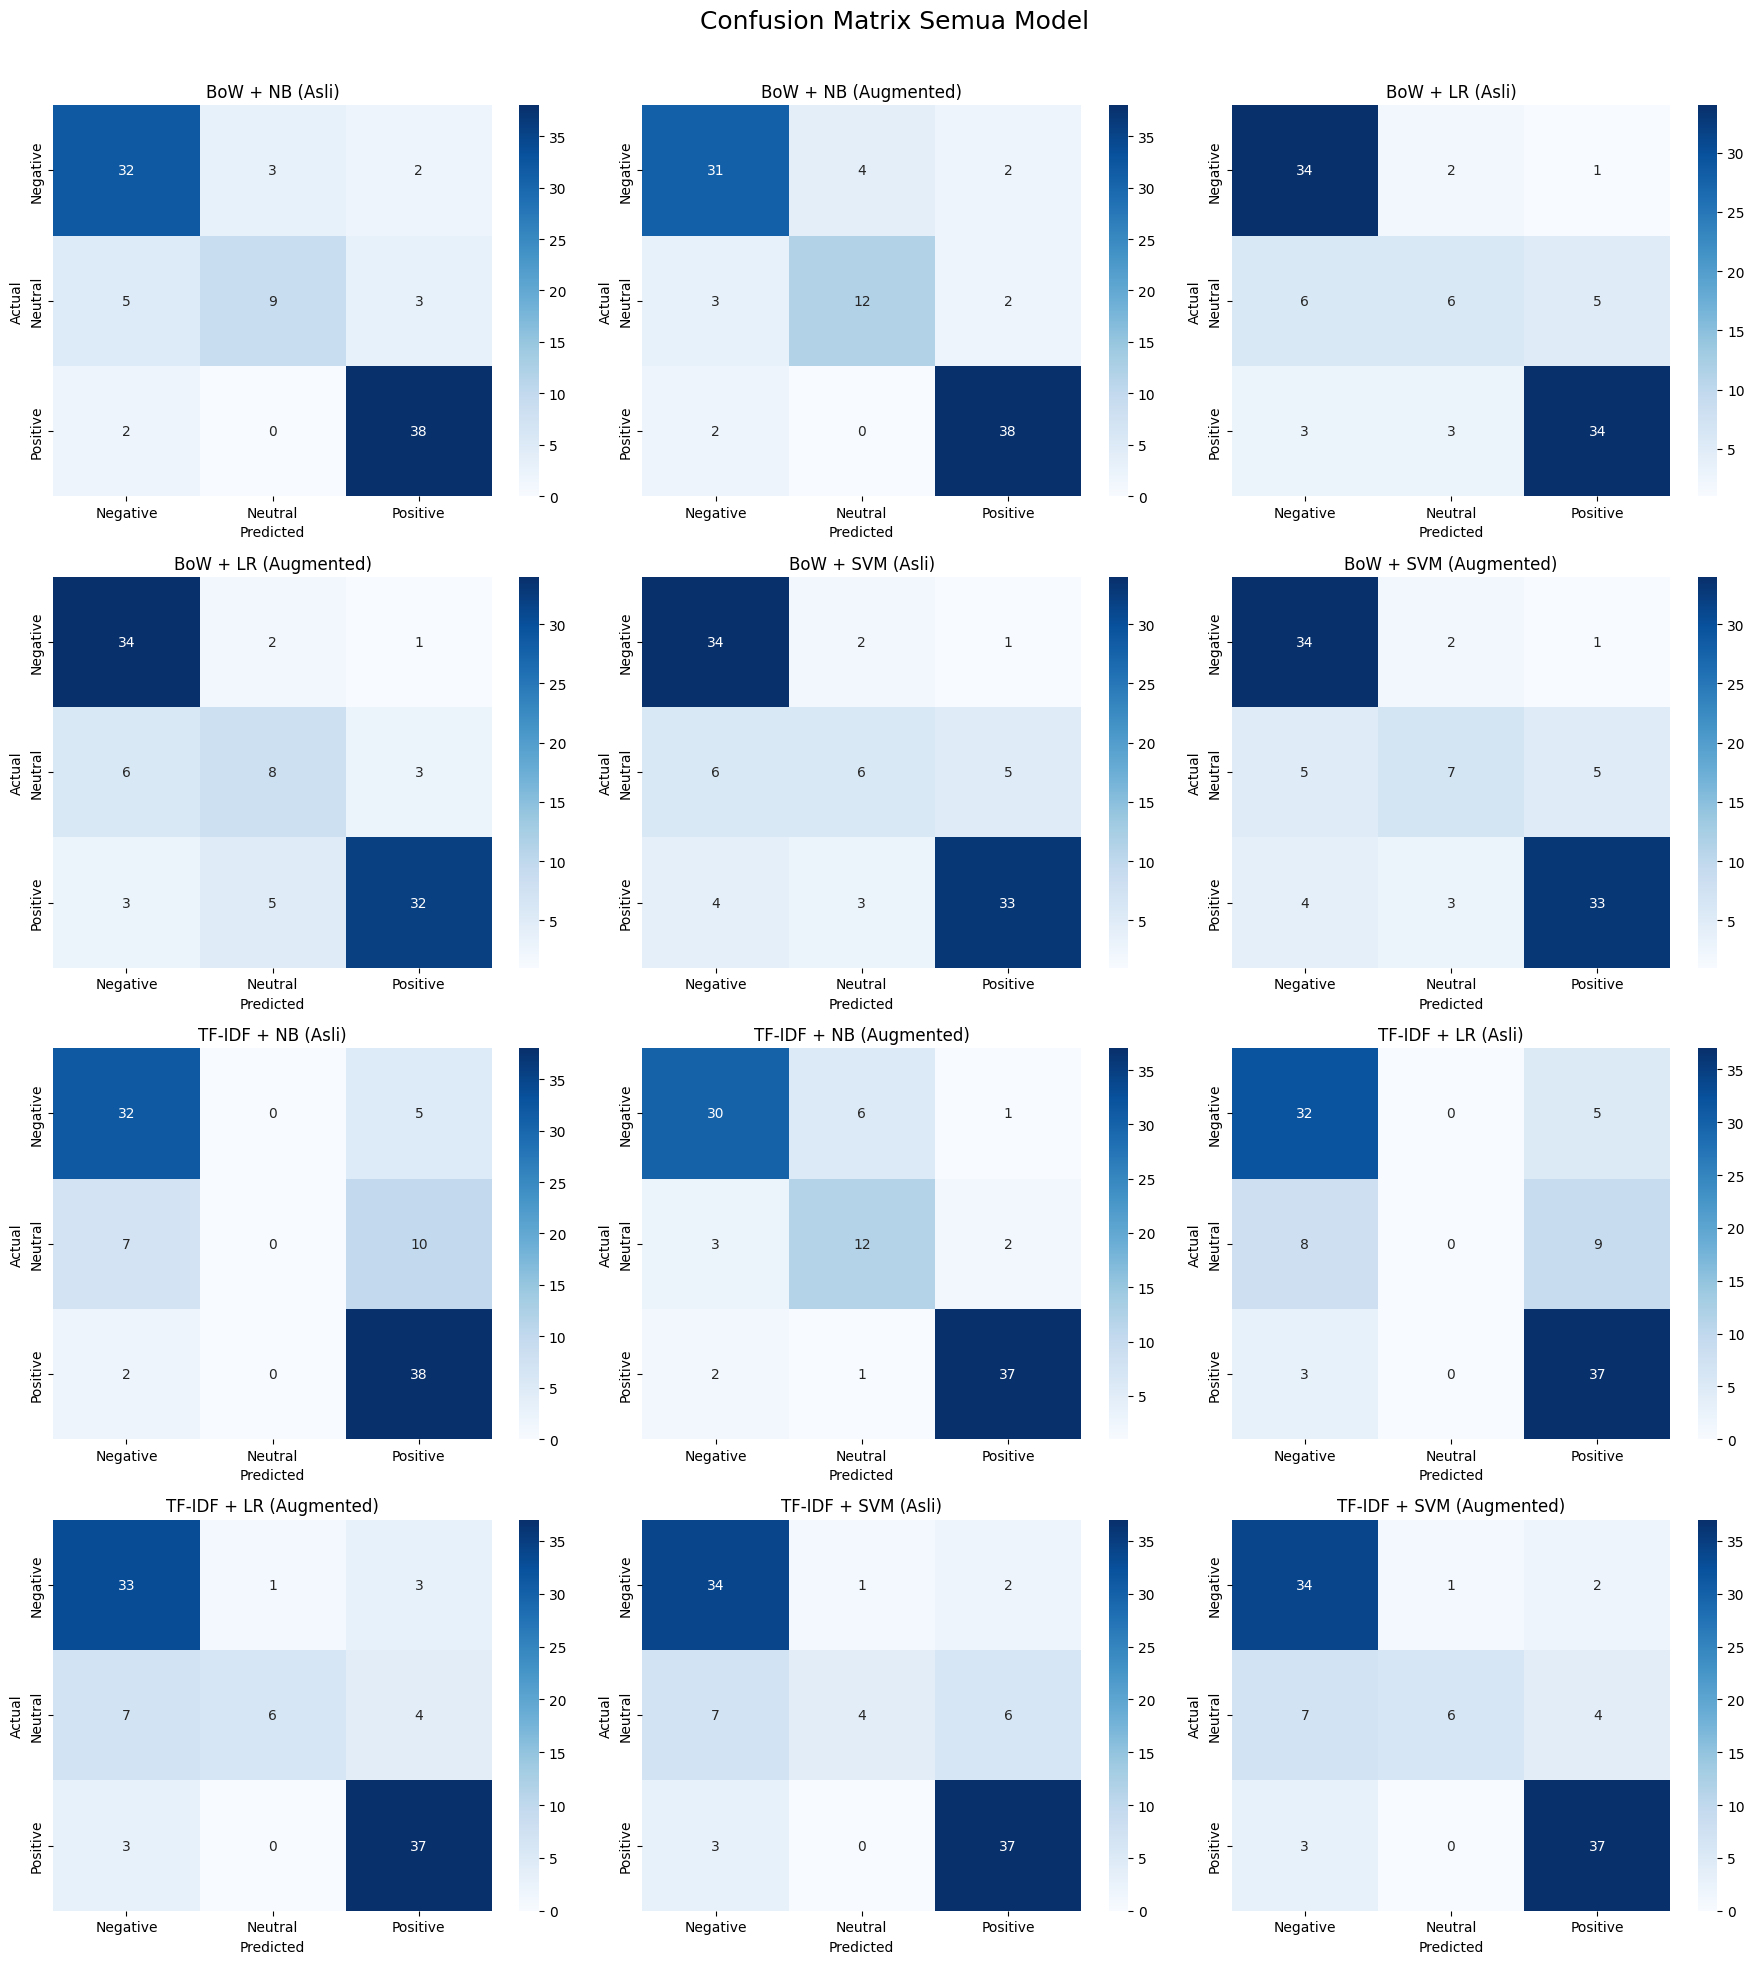

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

pipeline_bow_nb_aug = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB())
])
pipeline_bow_nb_aug.fit(X_train_aug_bert, y_train_aug_bert)

pipeline_bow_lr_aug = Pipeline([
    ('bow', CountVectorizer()),
    ('clf', LogisticRegression(max_iter=1000))
])
pipeline_bow_lr_aug.fit(X_train_aug_bert, y_train_aug_bert)

pipeline_bow_svm_aug = Pipeline([
    ('bow', CountVectorizer()),
    ('clf', LinearSVC())
])
pipeline_bow_svm_aug.fit(X_train_aug_bert, y_train_aug_bert)

# Daftar model dan prediksi
model_preds = {
    "BoW + NB (Asli)": pipeline_bow_nb_asli.predict(X_test),
    "BoW + NB (Augmented)": pipeline_bow_nb_aug.predict(X_test),
    "BoW + LR (Asli)": pipeline_bow_lr.predict(X_test),
    "BoW + LR (Augmented)": pipeline_bow_lr_aug.predict(X_test),
    "BoW + SVM (Asli)": pipeline_bow_svm.predict(X_test),
    "BoW + SVM (Augmented)": pipeline_bow_svm_aug.predict(X_test),
    "TF-IDF + NB (Asli)": pipeline_tfidf_nb.predict(X_test),
    "TF-IDF + NB (Augmented)": pipeline_tfidf_nb_aug.predict(X_test),
    "TF-IDF + LR (Asli)": pipeline_tfidf_lr.predict(X_test),
    "TF-IDF + LR (Augmented)": pipeline_tfidf_lr_aug.predict(X_test),
    "TF-IDF + SVM (Asli)": pipeline_tfidf_svm.predict(X_test),
    "TF-IDF + SVM (Augmented)": pipeline_tfidf_svm_aug.predict(X_test),
}

labels = ["Negative", "Neutral", "Positive"]

# Plot grid
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 20))
fig.suptitle("Confusion Matrix Semua Model", fontsize=18)

for ax, (model_name, y_pred) in zip(axes.flat, model_preds.items()):
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_title(model_name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


## Tabel Perbandingan

In [111]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score

# Simpan semua report dan akurasi
report_bow_nb = classification_report(y_test, pipeline_bow_nb_asli.predict(X_test), output_dict=True, zero_division=0)
acc_bow_nb = accuracy_score(y_test, pipeline_bow_nb_asli.predict(X_test))

report_bow_nb_aug = classification_report(y_test, pipeline_bow_nb_aug.predict(X_test), output_dict=True, zero_division=0)
acc_bow_nb_aug = accuracy_score(y_test, pipeline_bow_nb_aug.predict(X_test))

report_bow_lr = classification_report(y_test, pipeline_bow_lr.predict(X_test), output_dict=True, zero_division=0)
acc_bow_lr = accuracy_score(y_test, pipeline_bow_lr.predict(X_test))

report_bow_lr_aug = classification_report(y_test, pipeline_bow_lr_aug.predict(X_test), output_dict=True, zero_division=0)
acc_bow_lr_aug = accuracy_score(y_test, pipeline_bow_lr_aug.predict(X_test))

report_bow_svm = classification_report(y_test, pipeline_bow_svm.predict(X_test), output_dict=True, zero_division=0)
acc_bow_svm = accuracy_score(y_test, pipeline_bow_svm.predict(X_test))

report_bow_svm_aug = classification_report(y_test, pipeline_bow_svm_aug.predict(X_test), output_dict=True, zero_division=0)
acc_bow_svm_aug = accuracy_score(y_test, pipeline_bow_svm_aug.predict(X_test))

report_tfidf_nb = classification_report(y_test, pipeline_tfidf_nb.predict(X_test), output_dict=True, zero_division=0)
acc_tfidf_nb = accuracy_score(y_test, pipeline_tfidf_nb.predict(X_test))

report_tfidf_nb_aug = classification_report(y_test, pipeline_tfidf_nb_aug.predict(X_test), output_dict=True, zero_division=0)
acc_tfidf_nb_aug = accuracy_score(y_test, pipeline_tfidf_nb_aug.predict(X_test))

report_tfidf_lr = classification_report(y_test, pipeline_tfidf_lr.predict(X_test), output_dict=True, zero_division=0)
acc_tfidf_lr = accuracy_score(y_test, pipeline_tfidf_lr.predict(X_test))

report_tfidf_lr_aug = classification_report(y_test, pipeline_tfidf_lr_aug.predict(X_test), output_dict=True, zero_division=0)
acc_tfidf_lr_aug = accuracy_score(y_test, pipeline_tfidf_lr_aug.predict(X_test))

report_tfidf_svm = classification_report(y_test, pipeline_tfidf_svm.predict(X_test), output_dict=True, zero_division=0)
acc_tfidf_svm = accuracy_score(y_test, pipeline_tfidf_svm.predict(X_test))

report_tfidf_svm_aug = classification_report(y_test, pipeline_tfidf_svm_aug.predict(X_test), output_dict=True, zero_division=0)
acc_tfidf_svm_aug = accuracy_score(y_test, pipeline_tfidf_svm_aug.predict(X_test))

# Helper function
def extract_metrics(report, acc):
    return {
        "Accuracy": acc,
        "Macro F1": report["macro avg"]["f1-score"],
        "Negative Precision": report["Negative"]["precision"],
        "Negative Recall": report["Negative"]["recall"],
        "Negative F1": report["Negative"]["f1-score"],
        "Negative Support": report["Negative"]["support"],
        "Neutral Precision": report["Neutral"]["precision"],
        "Neutral Recall": report["Neutral"]["recall"],
        "Neutral F1": report["Neutral"]["f1-score"],
        "Neutral Support": report["Neutral"]["support"],
        "Positive Precision": report["Positive"]["precision"],
        "Positive Recall": report["Positive"]["recall"],
        "Positive F1": report["Positive"]["f1-score"],
        "Positive Support": report["Positive"]["support"]
    }

# Semua model
models = [
    ("BoW", "Naïve Bayes", "Asli", extract_metrics(report_bow_nb, acc_bow_nb)),
    ("BoW", "Naïve Bayes", "Augmented", extract_metrics(report_bow_nb_aug, acc_bow_nb_aug)),
    ("BoW", "Logistic Reg.", "Asli", extract_metrics(report_bow_lr, acc_bow_lr)),
    ("BoW", "Logistic Reg.", "Augmented", extract_metrics(report_bow_lr_aug, acc_bow_lr_aug)),
    ("BoW", "SVM", "Asli", extract_metrics(report_bow_svm, acc_bow_svm)),
    ("BoW", "SVM", "Augmented", extract_metrics(report_bow_svm_aug, acc_bow_svm_aug)),
    ("TF-IDF", "Naïve Bayes", "Asli", extract_metrics(report_tfidf_nb, acc_tfidf_nb)),
    ("TF-IDF", "Naïve Bayes", "Augmented", extract_metrics(report_tfidf_nb_aug, acc_tfidf_nb_aug)),
    ("TF-IDF", "Logistic Reg.", "Asli", extract_metrics(report_tfidf_lr, acc_tfidf_lr)),
    ("TF-IDF", "Logistic Reg.", "Augmented", extract_metrics(report_tfidf_lr_aug, acc_tfidf_lr_aug)),
    ("TF-IDF", "SVM", "Asli", extract_metrics(report_tfidf_svm, acc_tfidf_svm)),
    ("TF-IDF", "SVM", "Augmented", extract_metrics(report_tfidf_svm_aug, acc_tfidf_svm_aug)),
]

# Tabel per kelas
df_negative = pd.DataFrame([
    [f, a, d,
     round(m["Negative Precision"], 2),
     round(m["Negative Recall"], 2),
     round(m["Negative F1"], 2),
     int(m["Negative Support"])]
    for f, a, d, m in models
], columns=["Fitur", "Algoritma", "Data", "Precision", "Recall", "F1 Negative", "Support"])

df_neutral = pd.DataFrame([
    [f, a, d,
     round(m["Neutral Precision"], 2),
     round(m["Neutral Recall"], 2),
     round(m["Neutral F1"], 2),
     int(m["Neutral Support"])]
    for f, a, d, m in models
], columns=["Fitur", "Algoritma", "Data", "Precision", "Recall", "F1 Neutral", "Support"])

df_positive = pd.DataFrame([
    [f, a, d,
     round(m["Positive Precision"], 2),
     round(m["Positive Recall"], 2),
     round(m["Positive F1"], 2),
     int(m["Positive Support"])]
    for f, a, d, m in models
], columns=["Fitur", "Algoritma", "Data", "Precision", "Recall", "F1 Positive", "Support"])

df_overall = pd.DataFrame([
    [f, a, d, round(m["Accuracy"], 4), round(m["Macro F1"], 4)]
    for f, a, d, m in models
], columns=["Fitur", "Algoritma", "Data", "Accuracy", "Macro F1"])

# Tampilkan semua
print("\n=== TABEL NEGATIVE ===")
print(df_negative.to_string(index=False))

print("\n=== TABEL NEUTRAL ===")
print(df_neutral.to_string(index=False))

print("\n=== TABEL POSITIVE ===")
print(df_positive.to_string(index=False))

print("\n=== TABEL OVERALL METRIK ===")
print(df_overall.to_string(index=False))



=== TABEL NEGATIVE ===
 Fitur     Algoritma      Data  Precision  Recall  F1 Negative  Support
   BoW   Naïve Bayes      Asli       0.82    0.86         0.84       37
   BoW   Naïve Bayes Augmented       0.86    0.84         0.85       37
   BoW Logistic Reg.      Asli       0.79    0.92         0.85       37
   BoW Logistic Reg. Augmented       0.79    0.92         0.85       37
   BoW           SVM      Asli       0.77    0.92         0.84       37
   BoW           SVM Augmented       0.79    0.92         0.85       37
TF-IDF   Naïve Bayes      Asli       0.78    0.86         0.82       37
TF-IDF   Naïve Bayes Augmented       0.86    0.81         0.83       37
TF-IDF Logistic Reg.      Asli       0.74    0.86         0.80       37
TF-IDF Logistic Reg. Augmented       0.77    0.89         0.82       37
TF-IDF           SVM      Asli       0.77    0.92         0.84       37
TF-IDF           SVM Augmented       0.77    0.92         0.84       37

=== TABEL NEUTRAL ===
 Fitur     Algori

# CSV Mentahan

## Augmented + Train/test

In [113]:
import pandas as pd

# Gabungkan data latih dan uji
df_train = pd.DataFrame({
    "text": X_train_aug_bert,
    "label": y_train_aug_bert,
    "split": "train"
})

df_test = pd.DataFrame({
    "text": X_test,
    "label": y_test,
    "split": "test"
})

# Gabung jadi satu DataFrame
df_combined = pd.concat([df_train, df_test], ignore_index=True)

# Simpan ke CSV
df_combined.to_csv("garuda_combined_split.csv", index=False)
print(f"✅ CSV gabungan disimpan sebagai 'garuda_combined_split.csv' ({len(df_combined)} baris)")


✅ CSV gabungan disimpan sebagai 'garuda_combined_split.csv' (577 baris)


## + Label augmented/original

In [114]:
import pandas as pd

# Data latih asli
df_original = pd.DataFrame({
    "text": X_train.reset_index(drop=True),
    "label": y_train.reset_index(drop=True),
    "source": "original"
})

# Data hasil augmentasi
df_augmented = pd.DataFrame({
    "text": pd.Series(new_neutral_texts + new_negative_texts),
    "label": pd.Series(['Neutral'] * len(new_neutral_texts) + ['Negative'] * len(new_negative_texts)),
    "source": "augmented"
})

# Gabungkan
df_augmented_flagged = pd.concat([df_original, df_augmented], ignore_index=True)

# Simpan ke CSV
df_augmented_flagged.to_csv("garuda_augmented_flagged.csv", index=False)
print(f"✅ CSV gabungan disimpan sebagai 'garuda_augmented_flagged.csv' ({len(df_augmented_flagged)} baris)")


✅ CSV gabungan disimpan sebagai 'garuda_augmented_flagged.csv' (483 baris)
